In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/data/des81.b/data/tavangar/streams/code')
import glob

import numpy as np
import healpy as hp
import fitsio as fits
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.ndimage as nd
from utils import load_infiles

import ugali
from ugali import isochrone

import skymap, skymap.survey
from skymap.utils import cel2gal, gal2cel
from skymap.utils import setdefaults

from streamlib import skymap_factory
import streamlib
import results
import rotation_matrix
import plot_hess
import filter_data

import polyfit2d
from numpy.polynomial import polynomial

import importlib
import imp

import region_plot

/data/des81.b/data/tavangar/streams/code/streamlib.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/traitlets/config/application.py", line 658, i

In [2]:
sfd = hp.read_map('lambda_sfd_ebv.fits')
nside = hp.get_nside(sfd)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
sfd = sfd[galpix]

#planck = fitsio.read('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')['I_ML_FULL']
planck = hp.read_map('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')
nside = hp.get_nside(planck)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
planck = planck[galpix]

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/s1/tavangar/.local/lib/python2.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


## Plotting Functions

In [3]:
def stream_hess(data, phi1, phi2, phi1min, phi1max, stream_width, bkg_start):
    on = np.where((phi1<phi1max) & (phi1>phi1min)&(np.abs(phi2) < stream_width)) # on stream region
    onstream = data[on]
    print(len(onstream))

    off1 = np.where((phi1<phi1max) & (phi1>phi1min)& (phi2 > bkg_start) & (phi2 < bkg_start+2*stream_width))
    off2 = np.where((phi1<phi1max) & (phi1>phi1min)&(phi2 < (0-bkg_start)) & (phi2 > (0-(bkg_start+2*stream_width))))
    offstream1 = data[off1]
    offstream2 = data[off2]
    plt.scatter(onstream['MAG_SFD_G']-onstream['MAG_SFD_R'], onstream['MAG_SFD_G'], s = 0.01, c = 'b')
    plt.scatter(offstream1['MAG_SFD_G']-offstream1['MAG_SFD_R'], offstream1['MAG_SFD_G'], s = 0.01, c = 'r')
    plt.ylim(24, 16)
    plt.xlim(0,1)
    #plt.scatter(phi1[on], phi2[on], s = 0.001)
    #plt.scatter(rrl['ra'], rrl['dec'], s = 5, c='r')
    
    age = 1
    metal = 0.00001
    mu = 16.8
    mk = filter_data.mkpol(mu=mu, age=age, z=metal, dmu=0.5, C=[-0.02, 0.1], E=3., err=None, survey='DECaLS')

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1, im1 = plot_hess.plot_hess(onstream, offstream1, ax=ax1)
    plot_iso(iso, 'r')
    plt.plot(mk[:,0], mk[:,1]+mu, c='k')
    fig.colorbar(im1, ax = ax1)
    plt.xlim(0,1)
    plt.ylim(24, 16)
    plt.title('Subtract Region above for phi1 = [{},{}]'.format(phi1min, phi1max))

    ax2, im2 = plot_hess.plot_hess(onstream, offstream2, ax=ax2)
    plot_iso(iso, 'r')
    plt.plot(mk[:,0], mk[:,1]+mu, c='k')
    fig.colorbar(im2, ax = ax2)
    plt.xlim(0,1)
    plt.ylim(24, 16)
    plt.title('Subtract Region below for phi1 = [{},{}]'.format(phi1min, phi1max))
    
    return ax2, im2
    
def four_stream_hess(minmax_array):
    #fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))
    for i in range(len(minmax_array)):
        stream_hess(data, phi1, phi2, minmax_array[i][0], minmax_array[i][1], stream_width, bkg_start)
        
def plot_iso(iso,c):
    #plt.scatter(iso.mag_1-iso.mag_2,iso.mag_1+iso.distance_modulus,marker='o',c=c,s=3)
    plt.scatter(iso.data['g']-iso.data['r'],iso.data['g']+iso.distance_modulus,marker='o',c=c,s=3)
    #plt.gca().invert_yaxis()
    plt.xlabel('%s - %s'%(iso.band_1,iso.band_2)); plt.ylabel(iso.band_1)
    
def plot_iso2(iso,c):
    plt.scatter(iso.data['r']-iso.data['z'],iso.data['g']+iso.distance_modulus,marker='o',c=c,s=3)
    #plt.gca().invert_yaxis()
    plt.xlabel('%s - %s'%('r','z')); plt.ylabel(iso.band_1)

## Pal 13 Significance Measurement

In [ ]:
#load the des data to create the isochrones
filenames = glob.glob('/data/des81.b/data/tavangar/decals_south_skim/*.fits')
full_decals = load_infiles(filenames,columns=[
    'RA','DEC','MAG_SFD_G','MAG_SFD_R','MAG_SFD_Z','EXTENDED_CLASS'],multiproc=8)

In [ ]:
full_decals = full_decals[full_decals['EXTENDED_CLASS'] < 1]
full_decals = full_decals[(full_decals['MAG_SFD_G'] < 23.0) & (full_decals['MAG_SFD_G'] > 20.2)]
full_decals = full_decals[(full_decals['MAG_SFD_G']-full_decals['MAG_SFD_R'] < 1)
          &(full_decals['MAG_SFD_G']-full_decals['MAG_SFD_R'] > 0)]
sel1 = filter_data.select_isochrone(full_decals['MAG_SFD_G'], full_decals['MAG_SFD_R'], err=None, iso_params=[
        16.8, 13.5, 0.0001], C=[-0.02,0.1], E=2, gmin=20.2, survey='DECaLS')
#sel2 = filter_data.select_isochrone_grz(full_decals['MAG_SFD_G'], full_decals['MAG_SFD_R'], full_decals['MAG_SFD_Z'], 
#                                        err=None, iso_params=[16.8, 13.5, 0.0001], C=[-0.02,0.1], E=2, gmin=20.2, 
#                                        survey='DECaLS')
sel = sel1#&sel2
full_decals = full_decals[sel]
print(len(full_decals))

In [ ]:
# rotate everything
pal13_ends = [-9.8, 18.2, -15.7, 8.9] 
# rotate everything
phi1, phi2, R = streamlib.rotation(pal13_ends, full_decals['RA'], full_decals['DEC'])
print(phi1, phi2)
print(len(phi1))

3603
Using DES err!
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f206d9380d0>,
 <matplotlib.image.AxesImage at 0x7f206dad3050>)

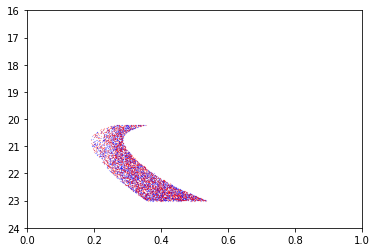

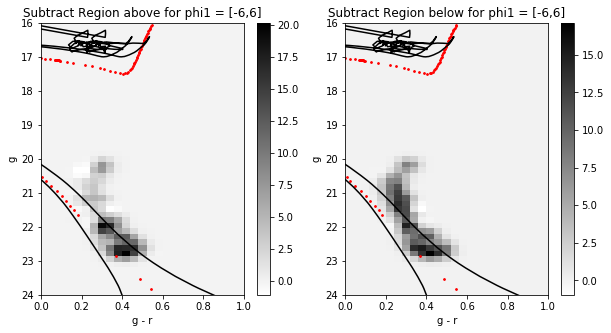

In [7]:
iso = isochrone.factory(name='Dotter2008',
                        age=12.8,  # Gyr
                        metallicity=0.0001, # Z
                        distance_modulus=16.8 #16.8 for left half of stream, 16.5 for right half
                       )

stream_width = 0.5
bkg_start = 1
stream_hess(full_decals, phi1, phi2, -6, 6, stream_width, bkg_start)

1643
1226
139
137
141
1280
9.20863309353


10.146158447905295

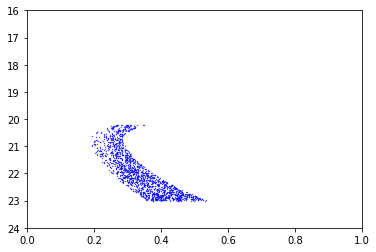

In [8]:
stream_width = 0.25
bkg_start = 1.75
phi1min, phi1max = -4.5,6.4
on = np.where((phi1<phi1max) & (phi1>phi1min)&(np.abs(phi2) < stream_width)
              & (np.abs(phi1)>0.4)) # on stream region
onstream = full_decals[on]
print(len(onstream))


off1 = np.where((phi1<phi1max) & (phi1>phi1min)& (phi2 > bkg_start) & (phi2 < bkg_start+2*stream_width)
                & (np.abs(phi1)>0.4))
off2 = np.where((phi1<phi1max) & (phi1>phi1min)&(phi2 < (0-bkg_start)) & (phi2 > (0-(bkg_start+2*stream_width)))
                & (np.abs(phi1)>0.4))
offstream1 = full_decals[off1]
offstream2 = full_decals[off2]
print(len(offstream2))
plt.scatter(onstream['MAG_SFD_G']-onstream['MAG_SFD_R'], onstream['MAG_SFD_G'], s = 0.1, c = 'b')
plt.ylim(24, 16)
plt.xlim(0,1)

#area correction
onpix = hp.ang2pix(256, onstream['RA'], onstream['DEC'], lonlat=True)
onpix = np.unique(onpix)
print(len(onpix))

offpix1 = hp.ang2pix(256, offstream1['RA'], offstream1['DEC'], lonlat=True)
offpix1 = np.unique(offpix1)
print(len(offpix1))

offpix2 = hp.ang2pix(256, offstream2['RA'], offstream2['DEC'], lonlat=True)
offpix2 = np.unique(offpix2)
print(len(offpix2))

offstream = (len(offstream1)+len(offstream2))/2
print(offstream)

scale_factor = np.float(offstream)/np.float(len(onpix))
print(scale_factor)
(len(onstream) - offstream)/np.sqrt(offstream)

In [9]:
#how many pixels for each region
#onstream area is 10 degrees by 0.5 degrees - part of 0.4 degree radius that is in the section (area is 0.372)
#off stream area is 10 degrees by 0.5 degrees
scale1 = 5/(5-0.372)

sigs, sig1s, sig2s = [], [], []
for back_start in np.linspace(0.5, 2., 151):
    on = np.where((phi1<phi1max) & (phi1>phi1min)&(np.abs(phi2) < stream_width)
              & (np.abs(phi1)>0.4)) # on stream region
    onstream = full_decals[on]

    off1 = np.where((phi1<phi1max) & (phi1>phi1min)& (phi2 > back_start) & (phi2 < back_start+2*stream_width)
                & (np.abs(phi1)>0.4))
    off2 = np.where((phi1<phi1max) & (phi1>phi1min)&(phi2 < (0-back_start)) & (phi2 > (0-(back_start+2*stream_width)))
                & (np.abs(phi1)>0.4))
    offstream1 = full_decals[off1]
    offstream2 = full_decals[off2]
    sig1 = (len(onstream) - len(offstream1))/np.sqrt(len(offstream1))
    sig2 = (len(onstream) - len(offstream2))/np.sqrt(len(offstream2))
    sig1s = np.append(sig1s, sig1)
    sig2s = np.append(sig2s, sig2)
    sigs = np.append(sigs, [sig1, sig2])
    
print(np.mean(sigs))
print(np.mean(sig1s))
print(np.mean(sig2s))

10.603580550319082
10.206459220437518
11.000701880200648


In [10]:
hpxcube1, fracdet1, modulus1 = region_plot.load_hpxcube(
    'DECaLS_iso_hpxcube_z0.0001_a13.5_gmax23_gmin3p4_E2_C-0p020p1.fits.gz')
#hpxcube1, fracdet1, modulus1 = region_plot.load_hpxcube(
#    'DECaLS_iso_hpxcube_z0.0001_a13.5_gmax23_gmin3p4_E2_C-0p020p1_w_zcut.fits.gz')
#hpxcube1, fracdet1, modulus1 = region_plot.load_hpxcube(
#    'DECaLS_iso_hpxcube_z0.00001_a01.0_gmax23_gmin3p4_E2_C-0p020p_gr.fits.gz')

Reading DECaLS_iso_hpxcube_z0.0001_a13.5_gmax23_gmin3p4_E2_C-0p020p1.fits.gz...
Skipping fracdet...


(5, -35)

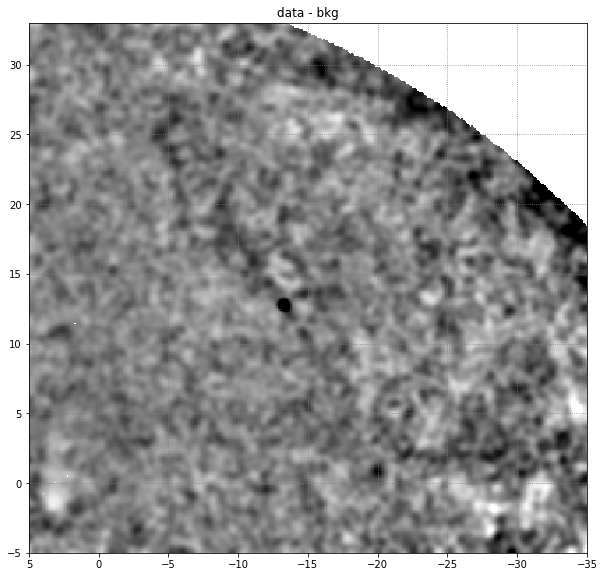

In [17]:
reload(region_plot)

data10 = region_plot.prepare_hpxmap(16.4, hpxcube1, fracdet1, modulus1)
data11 = region_plot.prepare_hpxmap(16.5, hpxcube1, fracdet1, modulus1)
data12 = region_plot.prepare_hpxmap(16.6, hpxcube1, fracdet1, modulus1)
data13 = region_plot.prepare_hpxmap(16.7, hpxcube1, fracdet1, modulus1)
data14 = region_plot.prepare_hpxmap(16.8, hpxcube1, fracdet1, modulus1)
data15 = region_plot.prepare_hpxmap(16.9, hpxcube1, fracdet1, modulus1)
data16 = region_plot.prepare_hpxmap(17.0, hpxcube1, fracdet1, modulus1)
data17 = region_plot.prepare_hpxmap(17.1, hpxcube1, fracdet1, modulus1)
data18 = region_plot.prepare_hpxmap(17.2, hpxcube1, fracdet1, modulus1)
data1 = (data10+data11+data12+data13+data14+data15+data16+data17+data18)/9
pal13_ends = [-9.8, 18.2, -15.7, 8.9]   
xx, yy, smooth = region_plot.run(data1,sigma=0.25, dust=sfd)
plt.xlim(5, -35)
#plt.ylim(-2,-2)

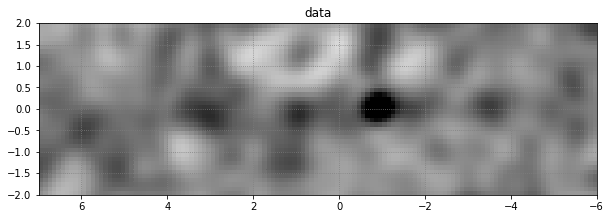

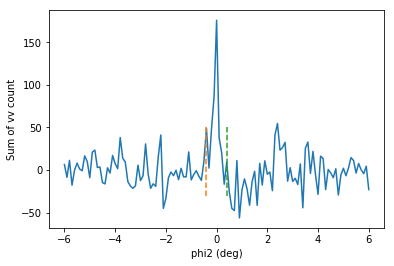

-6.046971381325278
23.271888870245633
significance = 7.82073008727


In [20]:
reload(region_plot)
reload(polyfit2d)

bkg_deg=5

data10 = region_plot.prepare_hpxmap(16.4, hpxcube1, fracdet1, modulus1)
data11 = region_plot.prepare_hpxmap(16.5, hpxcube1, fracdet1, modulus1)
data12 = region_plot.prepare_hpxmap(16.6, hpxcube1, fracdet1, modulus1)
data13 = region_plot.prepare_hpxmap(16.7, hpxcube1, fracdet1, modulus1)
data14 = region_plot.prepare_hpxmap(16.8, hpxcube1, fracdet1, modulus1)
data15 = region_plot.prepare_hpxmap(16.9, hpxcube1, fracdet1, modulus1)
data16 = region_plot.prepare_hpxmap(17.0, hpxcube1, fracdet1, modulus1)
data17 = region_plot.prepare_hpxmap(17.1, hpxcube1, fracdet1, modulus1)
data18 = region_plot.prepare_hpxmap(17.2, hpxcube1, fracdet1, modulus1)
data1 = (data10+data11+data12+data13+data14+data15+data16+data17+data18)/9
pal13_ends = [-9.8, 18.2, -15.7, 8.9]   
pp1, pp2, vv, res, smooth, vv_mask = region_plot.stream_coord_spatial(data1, pal13_ends,full_decals,
                                                                      bkg_deg, sigma=0.25)
plt.ylim(-2,2)
plt.show()


phi2_x = pp2[:,1]
ys = [] # sum of all vv for a given pp2 value
smooth[1]
for i in range(len(phi2_x)):
    s = np.sum(res[i, 15:]) - np.sum(res[i, 56:64])
    ys = np.append(ys, s)

plt.plot(phi2_x, ys)
plt.plot([-0.4,-0.4], [-30, 50], linestyle='dashed')
plt.plot([0.4,0.4], [-30, 50], linestyle='dashed')
plt.xlabel('phi2 (deg)')
plt.ylabel('Sum of vv count')
plt.show()

bg = np.append(ys[30:56], ys[-56:-30])

bg_mean = np.mean(bg)
print(bg_mean)

bg_std = np.std(bg)
print(bg_std)

sig = (np.max(ys[55:65]) - bg_mean) / bg_std
print('significance = {}'.format(sig))

## Background uncertainty measurement

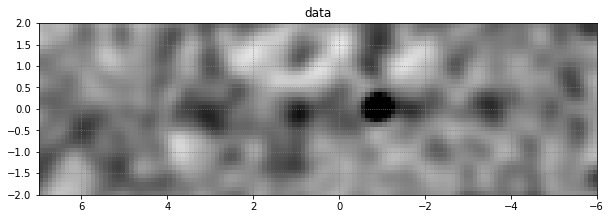

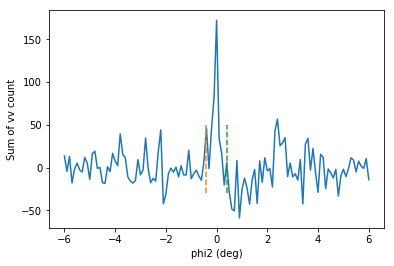

-5.532679196466864
24.139230504409905
significance = 7.36749661917


In [21]:
# larger degree background polynomial
reload(region_plot)
reload(polyfit2d)

bkg_deg=6

data10 = region_plot.prepare_hpxmap(16.4, hpxcube1, fracdet1, modulus1)
data11 = region_plot.prepare_hpxmap(16.5, hpxcube1, fracdet1, modulus1)
data12 = region_plot.prepare_hpxmap(16.6, hpxcube1, fracdet1, modulus1)
data13 = region_plot.prepare_hpxmap(16.7, hpxcube1, fracdet1, modulus1)
data14 = region_plot.prepare_hpxmap(16.8, hpxcube1, fracdet1, modulus1)
data15 = region_plot.prepare_hpxmap(16.9, hpxcube1, fracdet1, modulus1)
data16 = region_plot.prepare_hpxmap(17.0, hpxcube1, fracdet1, modulus1)
data17 = region_plot.prepare_hpxmap(17.1, hpxcube1, fracdet1, modulus1)
data18 = region_plot.prepare_hpxmap(17.2, hpxcube1, fracdet1, modulus1)
data1 = (data10+data11+data12+data13+data14+data15+data16+data17+data18)/9
pal13_ends = [-9.8, 18.2, -15.7, 8.9]   
pp1, pp2, vv, res, smooth, vv_mask = region_plot.stream_coord_spatial(data1, pal13_ends,full_decals,bkg_deg, sigma=0.2)
plt.ylim(-2,2)
plt.show()


phi2_x = pp2[:,1]
ys = [] # sum of all vv for a given pp2 value
smooth[1]
for i in range(len(phi2_x)):
    s = np.sum(res[i, 15:]) - np.sum(res[i, 56:64])
    ys = np.append(ys, s)

plt.plot(phi2_x, ys)
plt.plot([-0.4,-0.4], [-30, 50], linestyle='dashed')
plt.plot([0.4,0.4], [-30, 50], linestyle='dashed')
plt.xlabel('phi2 (deg)')
plt.ylabel('Sum of vv count')
plt.show()

bg = np.append(ys[30:56], ys[-56:-30])

bg_mean = np.mean(bg)
print(bg_mean)

bg_std = np.std(bg)
print(bg_std)

sig = (np.max(ys[55:65]) - bg_mean) / bg_std
print('significance = {}'.format(sig))

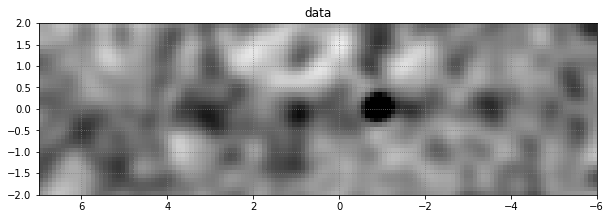

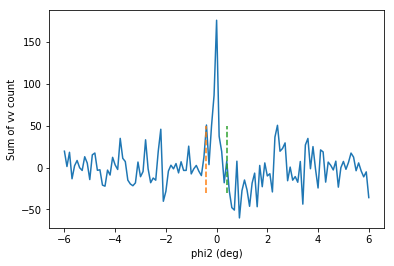

-6.101058052376275
23.792276736549976
significance = 7.64978744067


In [22]:
# smaller degree background polynomial
reload(region_plot)
reload(polyfit2d)

bkg_deg=4

data10 = region_plot.prepare_hpxmap(16.4, hpxcube1, fracdet1, modulus1)
data11 = region_plot.prepare_hpxmap(16.5, hpxcube1, fracdet1, modulus1)
data12 = region_plot.prepare_hpxmap(16.6, hpxcube1, fracdet1, modulus1)
data13 = region_plot.prepare_hpxmap(16.7, hpxcube1, fracdet1, modulus1)
data14 = region_plot.prepare_hpxmap(16.8, hpxcube1, fracdet1, modulus1)
data15 = region_plot.prepare_hpxmap(16.9, hpxcube1, fracdet1, modulus1)
data16 = region_plot.prepare_hpxmap(17.0, hpxcube1, fracdet1, modulus1)
data17 = region_plot.prepare_hpxmap(17.1, hpxcube1, fracdet1, modulus1)
data18 = region_plot.prepare_hpxmap(17.2, hpxcube1, fracdet1, modulus1)
data1 = (data10+data11+data12+data13+data14+data15+data16+data17+data18)/9
pal13_ends = [-9.8, 18.2, -15.7, 8.9]   
pp1, pp2, vv, res, smooth, vv_mask = region_plot.stream_coord_spatial(data1, pal13_ends,full_decals,bkg_deg, sigma=0.2)
plt.ylim(-2,2)
plt.show()


phi2_x = pp2[:,1]
ys = [] # sum of all vv for a given pp2 value
smooth[1]
for i in range(len(phi2_x)):
    s = np.sum(res[i, 15:]) - np.sum(res[i, 56:64])
    ys = np.append(ys, s)

plt.plot(phi2_x, ys)
plt.plot([-0.4,-0.4], [-30, 50], linestyle='dashed')
plt.plot([0.4,0.4], [-30, 50], linestyle='dashed')
plt.xlabel('phi2 (deg)')
plt.ylabel('Sum of vv count')
plt.show()

bg = np.append(ys[30:56], ys[-56:-30])

bg_mean = np.mean(bg)
print(bg_mean)

bg_std = np.std(bg)
print(bg_std)

sig = (np.max(ys[55:65]) - bg_mean) / bg_std
print('significance = {}'.format(sig))

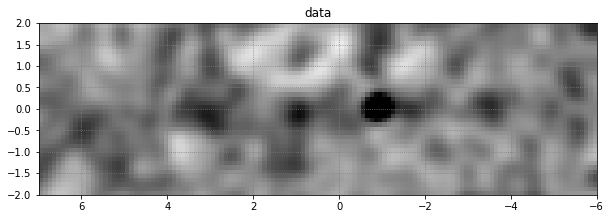

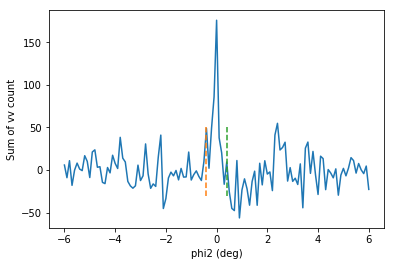

-6.075961850493733
23.28216802894503
significance = 7.81420322101


In [23]:
# lower limit of background (subtract all errors)

reload(region_plot)
reload(polyfit2d)

bkg_deg=5

data10 = region_plot.prepare_hpxmap(16.4, hpxcube1, fracdet1, modulus1)
data11 = region_plot.prepare_hpxmap(16.5, hpxcube1, fracdet1, modulus1)
data12 = region_plot.prepare_hpxmap(16.6, hpxcube1, fracdet1, modulus1)
data13 = region_plot.prepare_hpxmap(16.7, hpxcube1, fracdet1, modulus1)
data14 = region_plot.prepare_hpxmap(16.8, hpxcube1, fracdet1, modulus1)
data15 = region_plot.prepare_hpxmap(16.9, hpxcube1, fracdet1, modulus1)
data16 = region_plot.prepare_hpxmap(17.0, hpxcube1, fracdet1, modulus1)
data17 = region_plot.prepare_hpxmap(17.1, hpxcube1, fracdet1, modulus1)
data18 = region_plot.prepare_hpxmap(17.2, hpxcube1, fracdet1, modulus1)
data1 = (data10+data11+data12+data13+data14+data15+data16+data17+data18)/9
pal13_ends = [-9.8, 18.2, -15.7, 8.9]   
pp1, pp2, vv, res, smooth, vv_mask = region_plot.stream_coord_spatial(data1, pal13_ends,full_decals,bkg_deg, sigma=0.2)
plt.ylim(-2,2)
plt.show()


phi2_x = pp2[:,1]
ys = [] # sum of all vv for a given pp2 value
smooth[1]
for i in range(len(phi2_x)):
    s = np.sum(res[i, 15:]) - np.sum(res[i, 56:64])
    ys = np.append(ys, s)

plt.plot(phi2_x, ys)
plt.plot([-0.4,-0.4], [-30, 50], linestyle='dashed')
plt.plot([0.4,0.4], [-30, 50], linestyle='dashed')
plt.xlabel('phi2 (deg)')
plt.ylabel('Sum of vv count')
plt.show()

bg = np.append(ys[30:56], ys[-56:-30])

bg_mean = np.mean(bg)
print(bg_mean)

bg_std = np.std(bg)
print(bg_std)

sig = (np.max(ys[55:65]) - bg_mean) / bg_std
print('significance = {}'.format(sig))

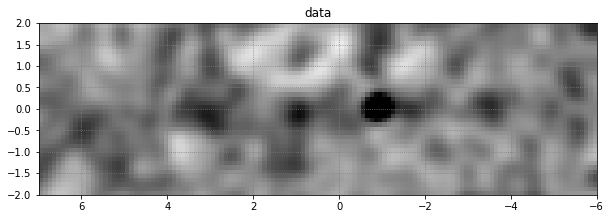

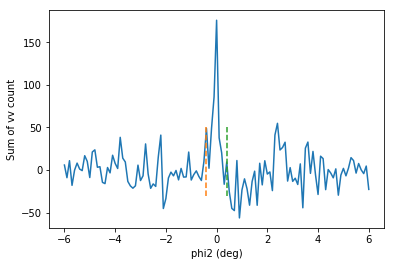

-6.075961850493733
23.28216802894503
significance = 7.81420322101


In [24]:
# upper limit of background (add all errors)

reload(region_plot)
reload(polyfit2d)

bkg_deg=5

data10 = region_plot.prepare_hpxmap(16.4, hpxcube1, fracdet1, modulus1)
data11 = region_plot.prepare_hpxmap(16.5, hpxcube1, fracdet1, modulus1)
data12 = region_plot.prepare_hpxmap(16.6, hpxcube1, fracdet1, modulus1)
data13 = region_plot.prepare_hpxmap(16.7, hpxcube1, fracdet1, modulus1)
data14 = region_plot.prepare_hpxmap(16.8, hpxcube1, fracdet1, modulus1)
data15 = region_plot.prepare_hpxmap(16.9, hpxcube1, fracdet1, modulus1)
data16 = region_plot.prepare_hpxmap(17.0, hpxcube1, fracdet1, modulus1)
data17 = region_plot.prepare_hpxmap(17.1, hpxcube1, fracdet1, modulus1)
data18 = region_plot.prepare_hpxmap(17.2, hpxcube1, fracdet1, modulus1)
data1 = (data10+data11+data12+data13+data14+data15+data16+data17+data18)/9
pal13_ends = [-9.8, 18.2, -15.7, 8.9]   
pp1, pp2, vv, res, smooth, vv_mask = region_plot.stream_coord_spatial(data1, pal13_ends,full_decals,bkg_deg, sigma=0.2)
plt.ylim(-2,2)
plt.show()


phi2_x = pp2[:,1]
ys = [] # sum of all vv for a given pp2 value
smooth[1]
for i in range(len(phi2_x)):
    s = np.sum(res[i, 15:]) - np.sum(res[i, 56:64])
    ys = np.append(ys, s)

plt.plot(phi2_x, ys)
plt.plot([-0.4,-0.4], [-30, 50], linestyle='dashed')
plt.plot([0.4,0.4], [-30, 50], linestyle='dashed')
plt.xlabel('phi2 (deg)')
plt.ylabel('Sum of vv count')
plt.show()

bg = np.append(ys[30:56], ys[-56:-30])

bg_mean = np.mean(bg)
print(bg_mean)

bg_std = np.std(bg)
print(bg_std)

sig = (np.max(ys[55:65]) - bg_mean) / bg_std
print('significance = {}'.format(sig))

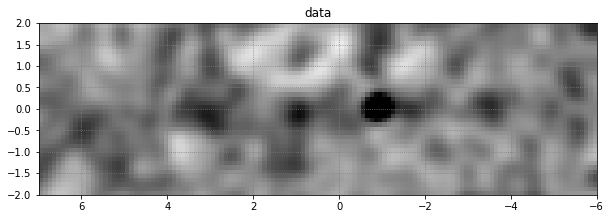

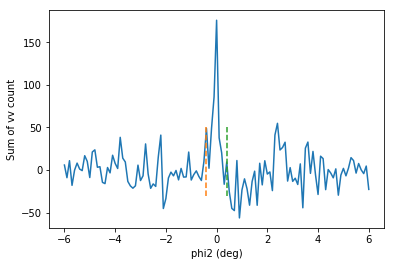

-6.075961850493733
23.28216802894503
significance = 7.81420322101


In [25]:
# Random uncertainty in coeffs

reload(region_plot)
reload(polyfit2d)

bkg_deg=5

data10 = region_plot.prepare_hpxmap(16.4, hpxcube1, fracdet1, modulus1)
data11 = region_plot.prepare_hpxmap(16.5, hpxcube1, fracdet1, modulus1)
data12 = region_plot.prepare_hpxmap(16.6, hpxcube1, fracdet1, modulus1)
data13 = region_plot.prepare_hpxmap(16.7, hpxcube1, fracdet1, modulus1)
data14 = region_plot.prepare_hpxmap(16.8, hpxcube1, fracdet1, modulus1)
data15 = region_plot.prepare_hpxmap(16.9, hpxcube1, fracdet1, modulus1)
data16 = region_plot.prepare_hpxmap(17.0, hpxcube1, fracdet1, modulus1)
data17 = region_plot.prepare_hpxmap(17.1, hpxcube1, fracdet1, modulus1)
data18 = region_plot.prepare_hpxmap(17.2, hpxcube1, fracdet1, modulus1)
data1 = (data10+data11+data12+data13+data14+data15+data16+data17+data18)/9
pal13_ends = [-9.8, 18.2, -15.7, 8.9]   
pp1, pp2, vv, res, smooth, vv_mask = region_plot.stream_coord_spatial(data1, pal13_ends,full_decals,bkg_deg, sigma=0.2)
plt.ylim(-2,2)
plt.show()


phi2_x = pp2[:,1]
ys = [] # sum of all vv for a given pp2 value
smooth[1]
for i in range(len(phi2_x)):
    s = np.sum(res[i, 15:]) - np.sum(res[i, 56:64])
    ys = np.append(ys, s)

plt.plot(phi2_x, ys)
plt.plot([-0.4,-0.4], [-30, 50], linestyle='dashed')
plt.plot([0.4,0.4], [-30, 50], linestyle='dashed')
plt.xlabel('phi2 (deg)')
plt.ylabel('Sum of vv count')
plt.show()

bg = np.append(ys[30:56], ys[-56:-30])

bg_mean = np.mean(bg)
print(bg_mean)

bg_std = np.std(bg)
print(bg_std)

sig = (np.max(ys[55:65]) - bg_mean) / bg_std
print('significance = {}'.format(sig))

significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
significance = 7.85207636553
('Average Significance: ', 7.852076365533148)
('Significance Standard Deviation: ', 8.881784197001252e-16)


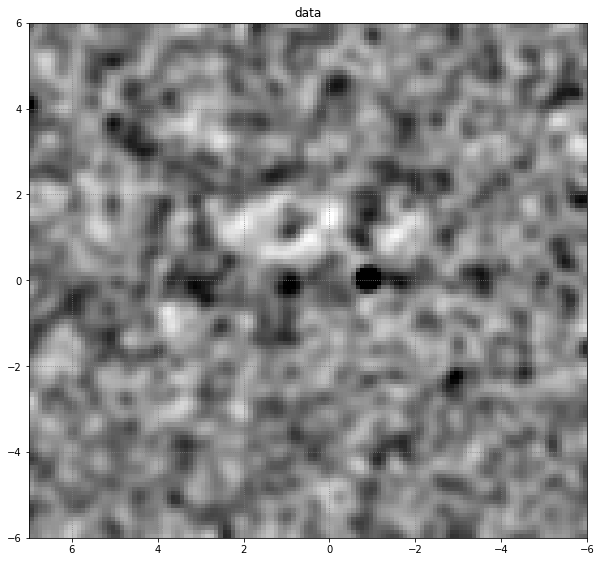

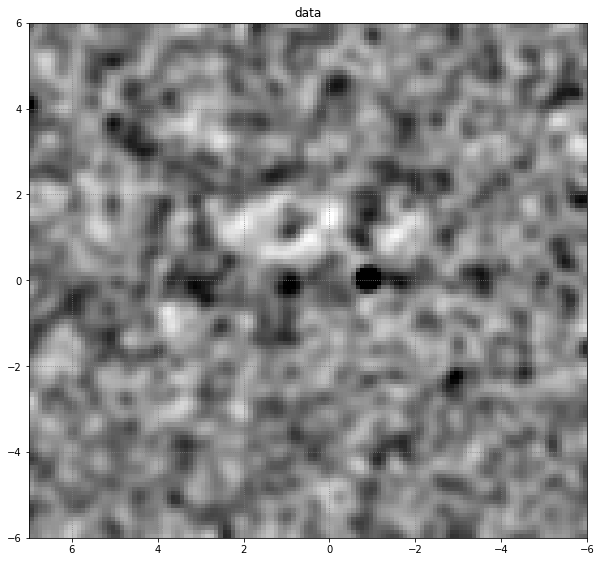

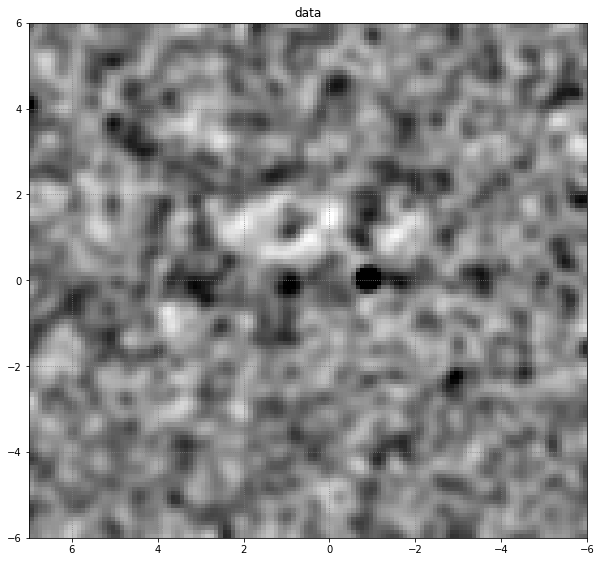

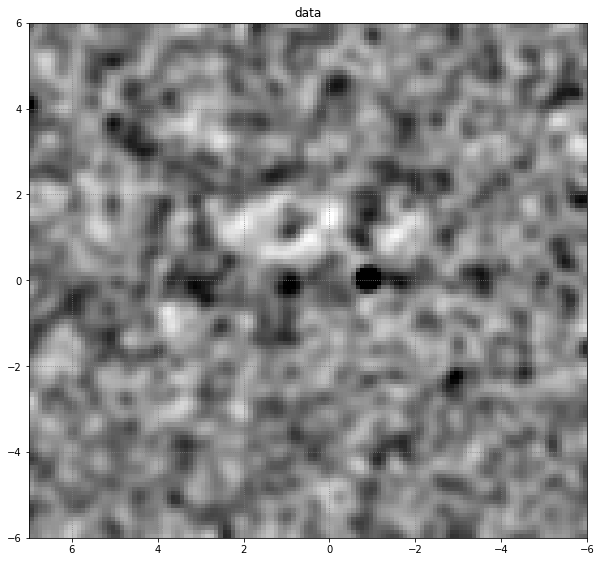

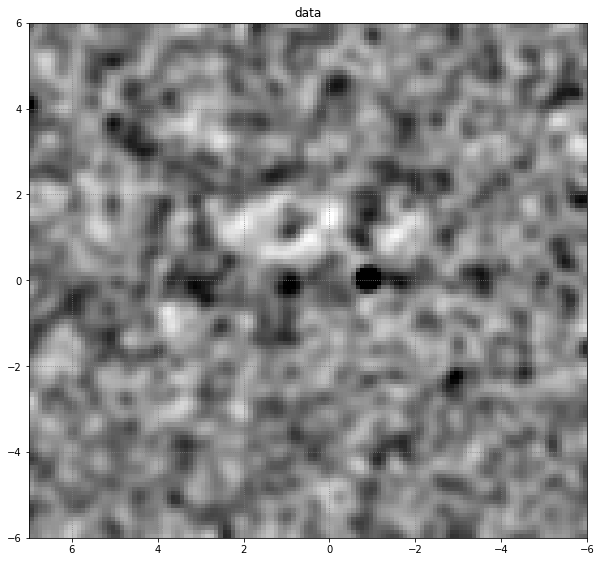

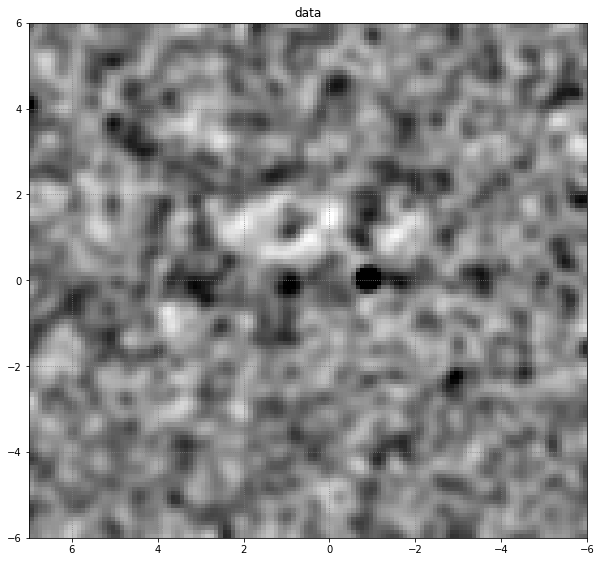

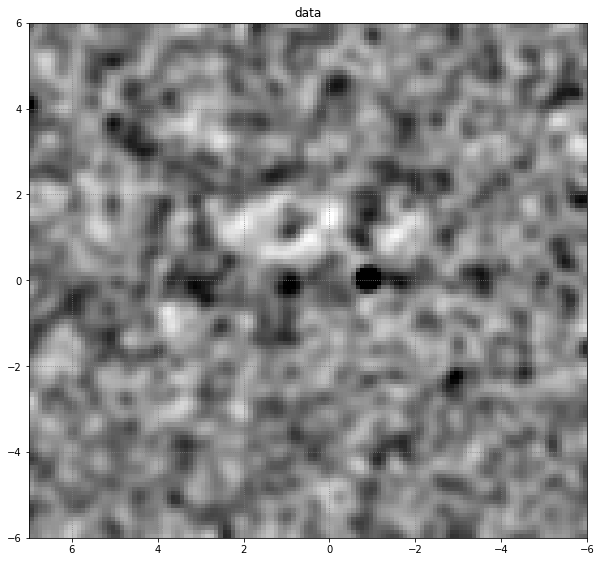

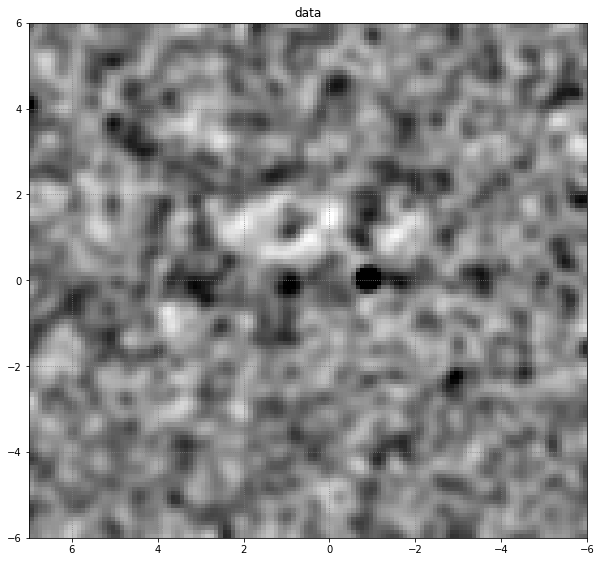

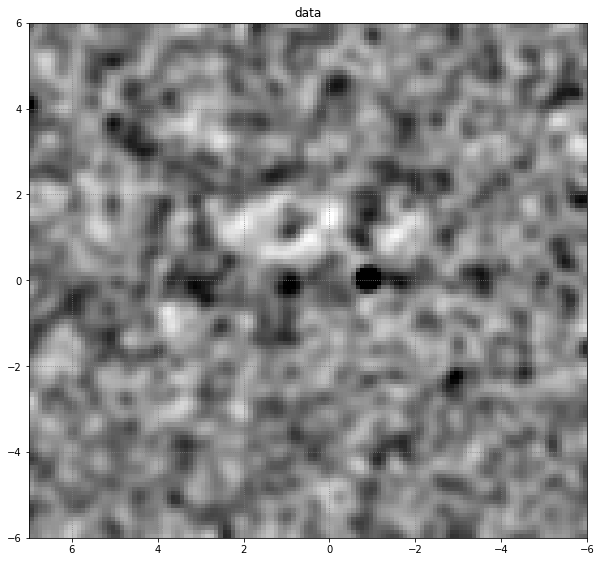

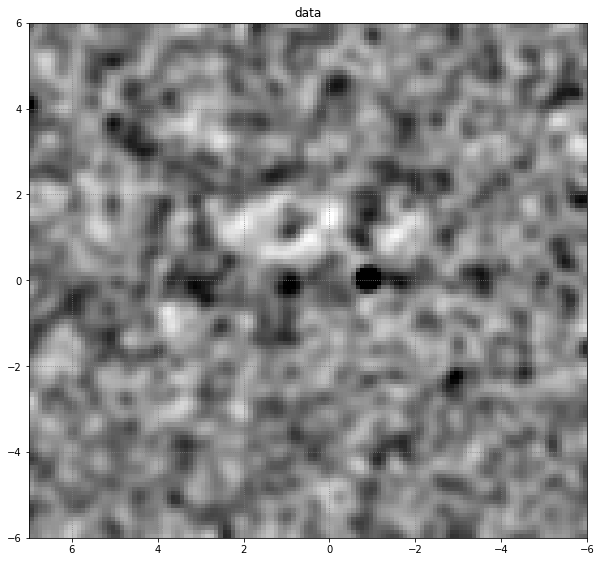

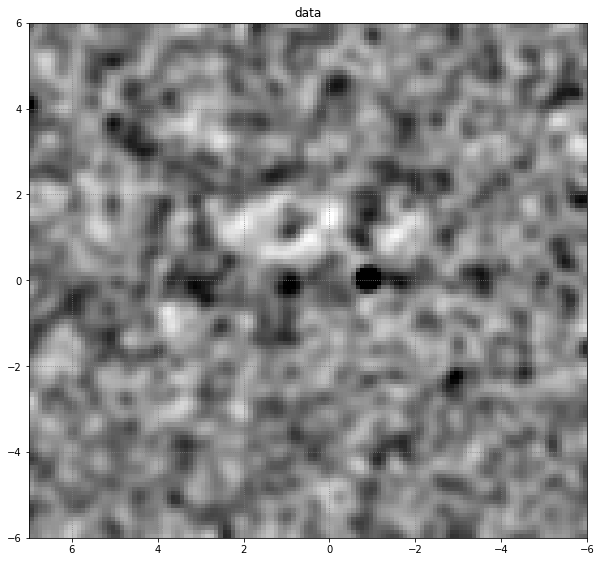

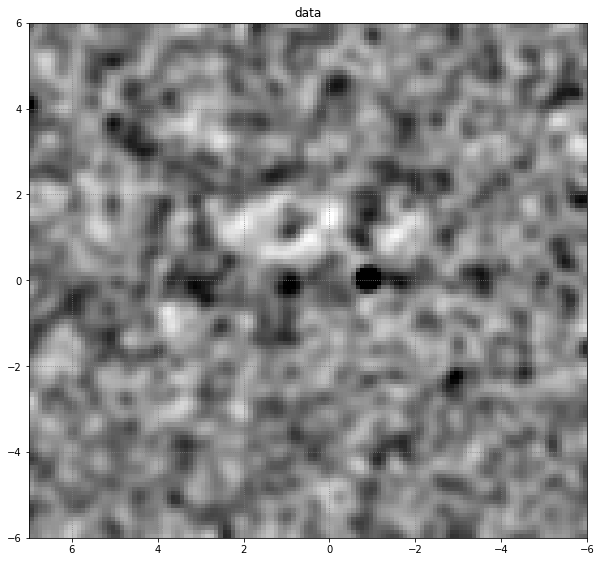

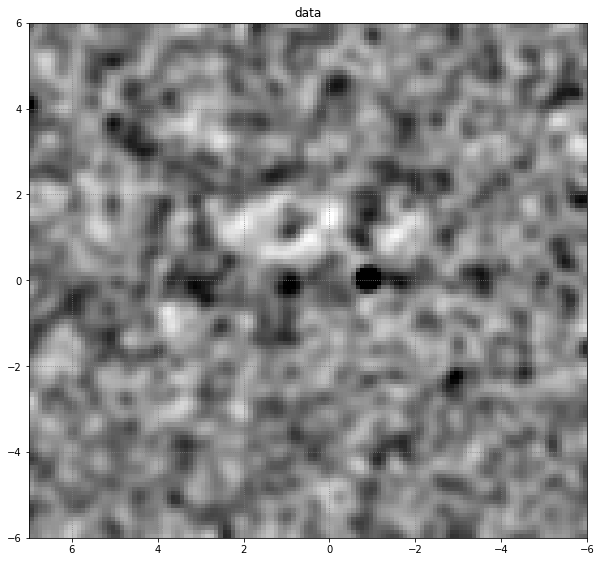

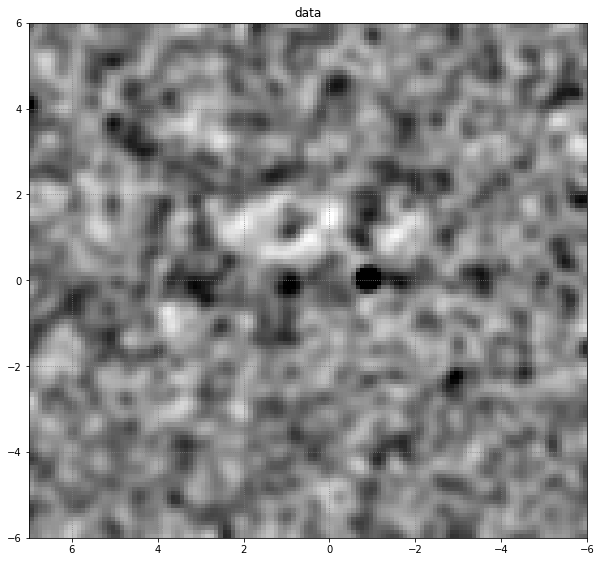

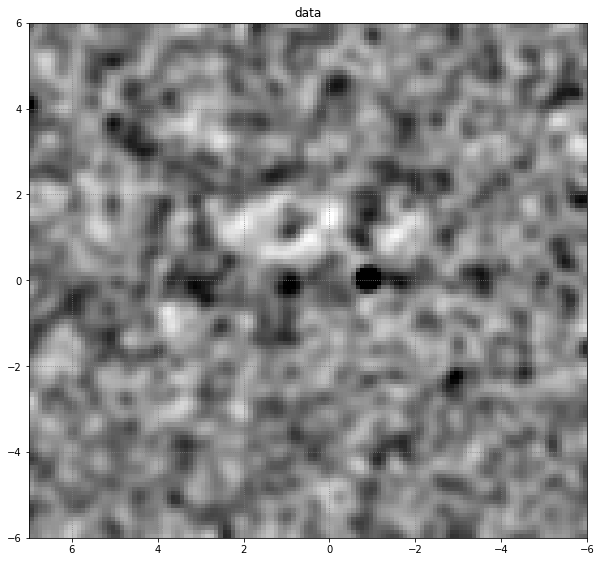

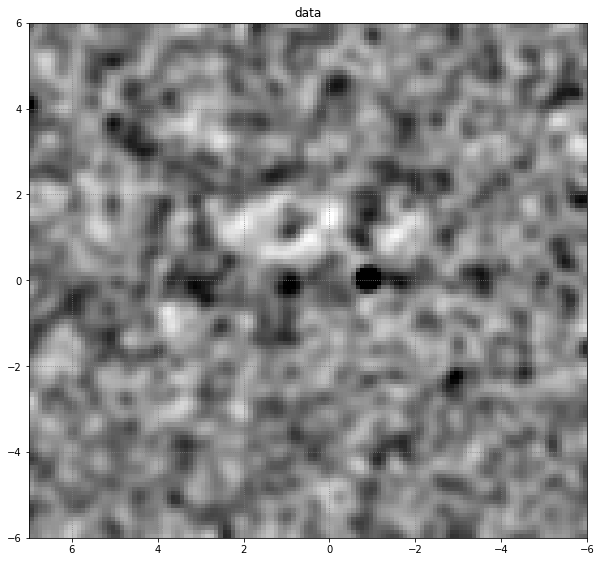

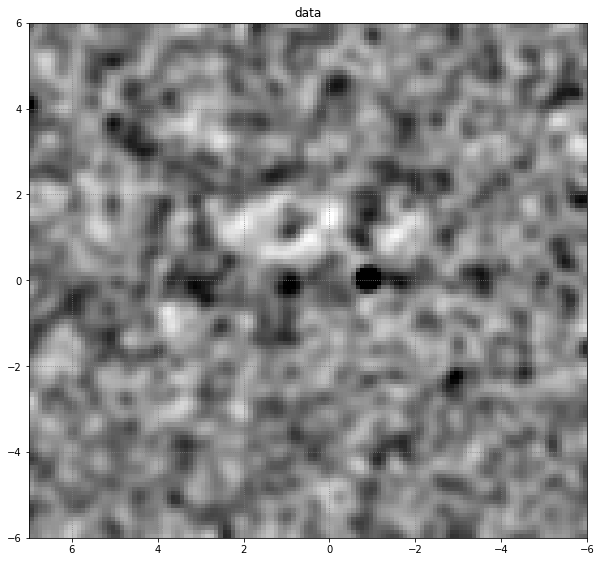

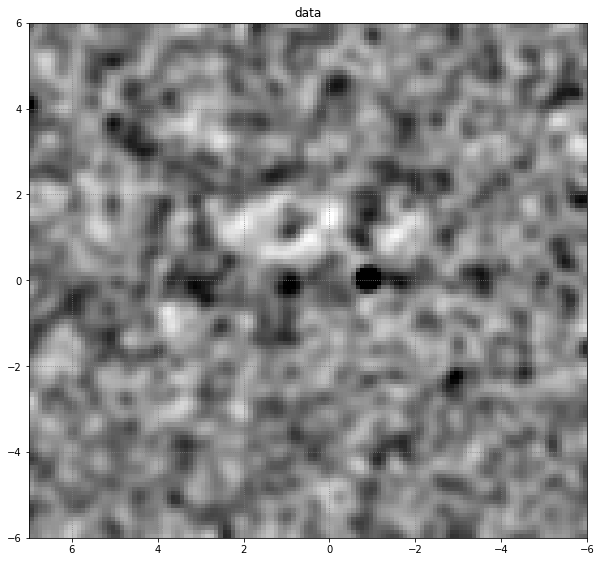

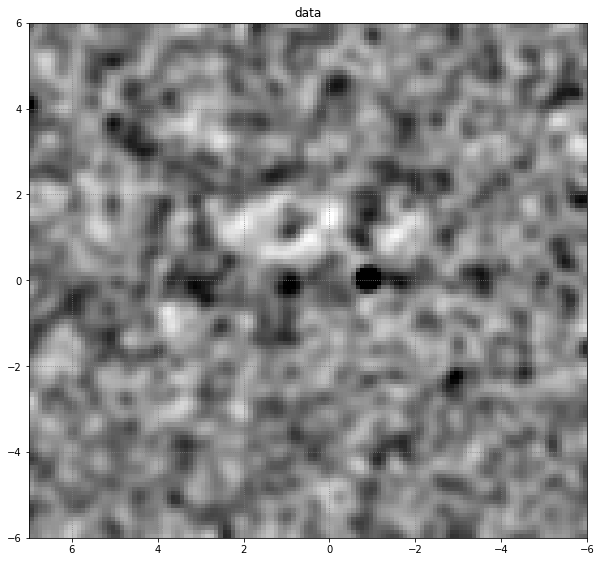

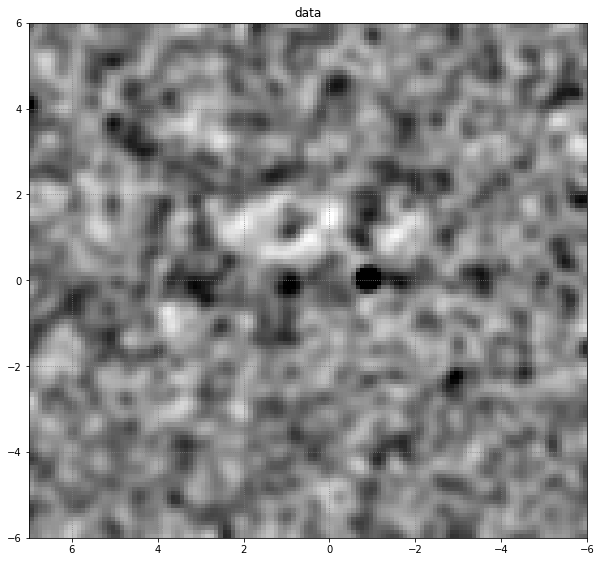

In [26]:
# Calculation of average significance given random uncertainties in the coefficients

# this is overkill, but coded it for the future potentially

reload(region_plot)
reload(polyfit2d)
def sig_calc(size):
    sigs = []
    for i in range(size):
        data10 = region_plot.prepare_hpxmap(16.4, hpxcube1, fracdet1, modulus1)
        data11 = region_plot.prepare_hpxmap(16.5, hpxcube1, fracdet1, modulus1)
        data12 = region_plot.prepare_hpxmap(16.6, hpxcube1, fracdet1, modulus1)
        data13 = region_plot.prepare_hpxmap(16.7, hpxcube1, fracdet1, modulus1)
        data14 = region_plot.prepare_hpxmap(16.8, hpxcube1, fracdet1, modulus1)
        data15 = region_plot.prepare_hpxmap(16.9, hpxcube1, fracdet1, modulus1)
        data16 = region_plot.prepare_hpxmap(17.0, hpxcube1, fracdet1, modulus1)
        data17 = region_plot.prepare_hpxmap(17.1, hpxcube1, fracdet1, modulus1)
        data18 = region_plot.prepare_hpxmap(17.2, hpxcube1, fracdet1, modulus1)
        data1 = (data10+data11+data12+data13+data14+data15+data16+data17+data18)/9
        pal13_ends = [-9.8, 18.2, -15.7, 8.9]   
        pp1, pp2, vv, res, smooth, vv_mask = region_plot.stream_coord_spatial(data1, pal13_ends,full_decals,
                                                                              bkg_deg,sigma=0.15)
        
        phi2_x = pp2[:,1]
        ys = [] # sum of all vv for a given pp2 value
        smooth[1]
        for i in range(len(phi2_x)):
            s = np.sum(res[i, 10:-10]) - np.sum(res[i, 56:64])
            ys = np.append(ys, s)
            
        bg = np.append(ys[30:56], ys[-54:-30])

        bg_mean = np.mean(bg)

        bg_std = np.std(bg)

        sig = (np.max(ys[55:65]) - bg_mean) / bg_std
        print('significance = {}'.format(sig))
        
        sigs = np.append(sigs,sig)
        
    s = np.mean(sigs)
    std_sig = np.std(sigs)
    print('Average Significance: ', s)
    print('Significance Standard Deviation: ', std_sig)
    return s

s = sig_calc(20)

In [27]:
# other version of on-off significance, make sure correct background is being used

on=0
print(pp1[1,15:-6])
for i in range(58,63):
    on += (np.sum(res[i, 15:-6]) - np.sum(res[i, 56:65]))
print(on)
    
off = 0
for i in range(37,42):
    off += (np.sum(res[i, 15:-6]) - np.sum(res[i, 56:65]))
print(off)
print(pp1[i,56:65])

sig = (on-off)/np.sqrt(-off)
print(sig)

[-4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7 -3.6 -3.5 -3.4 -3.3 -3.2
 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3 -2.2 -2.1 -2.  -1.9 -1.8
 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4
 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.
  1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4
  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8
  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2
  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4]
346.6340684626491
-9.829791101562275
[-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]
113.69552222427536
